In [3]:
import gym
import gym_robot
import os
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPool2D
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.optimizers import Adam
from keras import backend as K
import rl.core
from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory
import matplotlib.pyplot as plt

"""
シミュレーター環境の前処理としてProcessorを実装しgymの入出力を調整
"""
class RobotProcessor(rl.core.Processor):
    def __init__(self, enable_image=False, reshape_size=(64, 48)):
        self.shape = reshape_size
        self.enable_image = enable_image

    def process_action(self, action):
        ACT_ID_TO_VALUE = {
            0: 50, 
            1: 25,
            2: -25,
            3: -50
        }
        return ACT_ID_TO_VALUE[action]

"""
シミュレーター環境参照・構築
"""
env = gym.make("myenv-v0") #シミュレーター環境構築
nb_actions = env.action_space.n 
window_length = 10 #観測値を何個連結して処理するかの値
processor = RobotProcessor(enable_image=True, reshape_size=(64, 48))
memory = SequentialMemory(limit=50000, window_length=window_length, ignore_episode_boundaries=True)

"""
学習ネットワークの定義・設定
"""
model = Sequential()
model.add(Conv2D(32,3,input_shape=(window_length,)+(64,48))) #入力層(ニューロン数固定)
model.add(Activation('relu'))
model.add(Conv2D(32,3))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64,3))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(1,2)))
model.add(Flatten())
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dropout(1.0))
model.add(Dense(nb_actions, activation='linear')) #出力層(ニューロン数固定)

"""
学習ネットワークの定義・設定
"""
agent = DQNAgent(nb_actions=nb_actions, memory=memory, gamma = 0.80, batch_size=32, nb_steps_warmup=500, 
                 train_interval=1, memory_interval=1,model=model, policy=EpsGreedyQPolicy(eps=0.1), processor=processor)

agent.compile(optimizer=Adam(lr=1e-3))



--- start ---
'Ctrl + C' is stop.
Training for 25000 steps ...
Interval 1 (0 steps performed)

done, took 202.686 seconds


KeyError: 'nb_episode_steps'

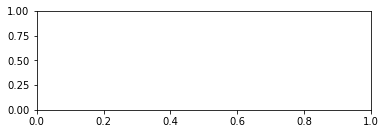

In [2]:
"""
訓練開始
"""
print("--- start ---")
print("'Ctrl + C' is stop.")
history = agent.fit(env, nb_steps=25000, log_interval=100, visualize=False, verbose=1)


"""
訓練終了時に結果を表示
"""
plt.subplot(2,1,1)
plt.plot(history.history["nb_episode_steps"]) #各エピソード時のステップ数を表示
plt.ylabel("step")

plt.subplot(2,1,2)
plt.plot(history.history["episode_reward"]) #各エピソード時の報酬値を表示
plt.xlabel("episode")
plt.ylabel("reward")

plt.show()

"""
今回の訓練で得たモデルの重みをh5fファイルとして保存
"""
agent.save_weights("duel_dqn_{}_weights.h5f".format("myenv-v0"), overwrite=True)

In [ ]:
"""
訓練結果を生成したモデルの重みを利用して確認する
"""

filepath = 'duel_dqn_myenv-v0_weights.h5f' #利用するモデルの重みファイル名を指定
agent.load_weights(filepath) #利用するモデルを参照
agent.test(env, nb_episodes=5, visualize=False) #MAX_STEPS(robot_env.py)が1000に到達すると1エピソードが終了する